### Visualization of intermediate activations

In [2]:
import keras
from keras.models import load_model
model = load_model('/Users/dawidkubicki/Documents/dataset/cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

### Processing of a single photo

In [10]:
img_path = '/Users/dawidkubicki/Documents/dataset/cats_and_dogs_small/test/cats/cat.2100.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

print(img_tensor.shape)

(1, 150, 150, 3)


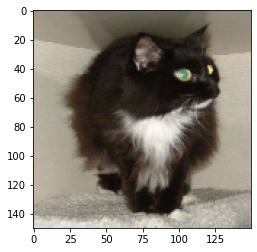

In [14]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])

### Creating instance of the model according to input tensor and list of output tensors

In [15]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] #8 top layers
activation_model = models.Model(inputs=model.input, outputs)

### Launching model in generative of predictions mode 

In [20]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


In [26]:
print(first_layer_activation[0,:,:,3])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Let's check 4-th channel of activation 

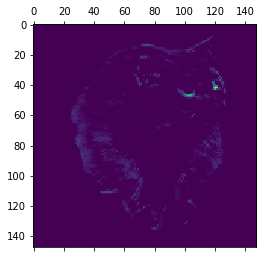

In [17]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

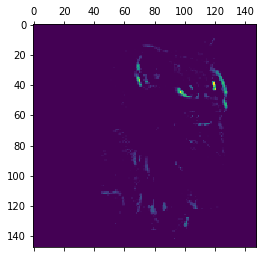

In [19]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')
plt.show()

### Visualization of all the channels of intermediate layer of activations

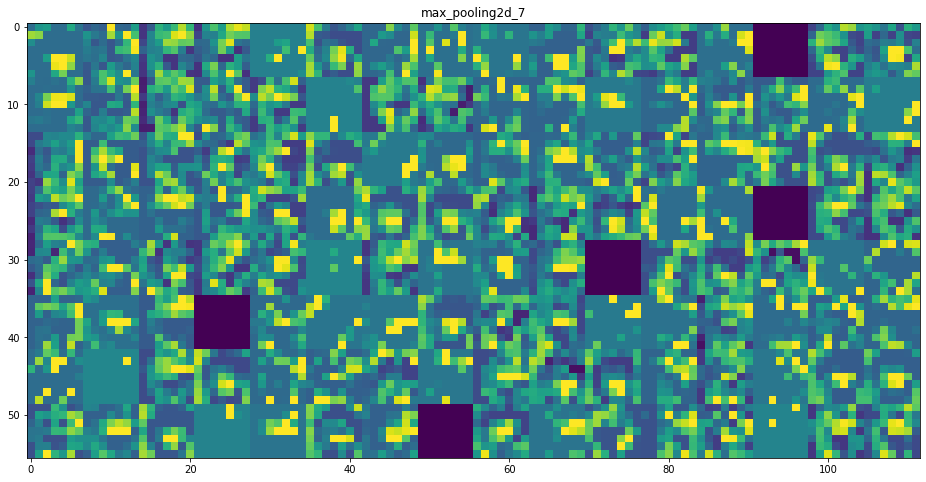

In [33]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    
display_grid = np.zeros((size * n_cols, images_per_row*size))

for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = layer_activation[0,
                                        :, :,
                                        col*images_per_row+row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col*size:(col+1) * size,
                    row*size:(row+1) * size] = channel_image
            
scale = 1. / size
plt.figure(figsize=(scale*display_grid.shape[1],
                       scale*display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

### Visualizing filters of convolutional neural networks

#### Cool way of investigating filters is to increase gradient in the entrance space: using gradient descent algorithm on input image value of convolutional neural network.

In [41]:
from keras.applications import VGG16
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

model = VGG16(weights='imagenet',
             include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:, filter_index])

#### Let's get the gradient descent values with input values

In [42]:
grads = K.gradients(loss, model.input)[0]

In [43]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [44]:
iterate = K.function([model.input],[loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1,150,150,3))])

In [45]:
input_img_data = np.random.random((1,150,150,3)) * 20 + 128.

step = 1.

for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value*step

### Function to process tensor for image

In [52]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Function generating filter visualizatioon

In [53]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value*step
        
    img = input_img_data[0]
    return deprocess_image(img)

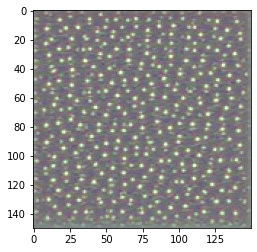

In [54]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


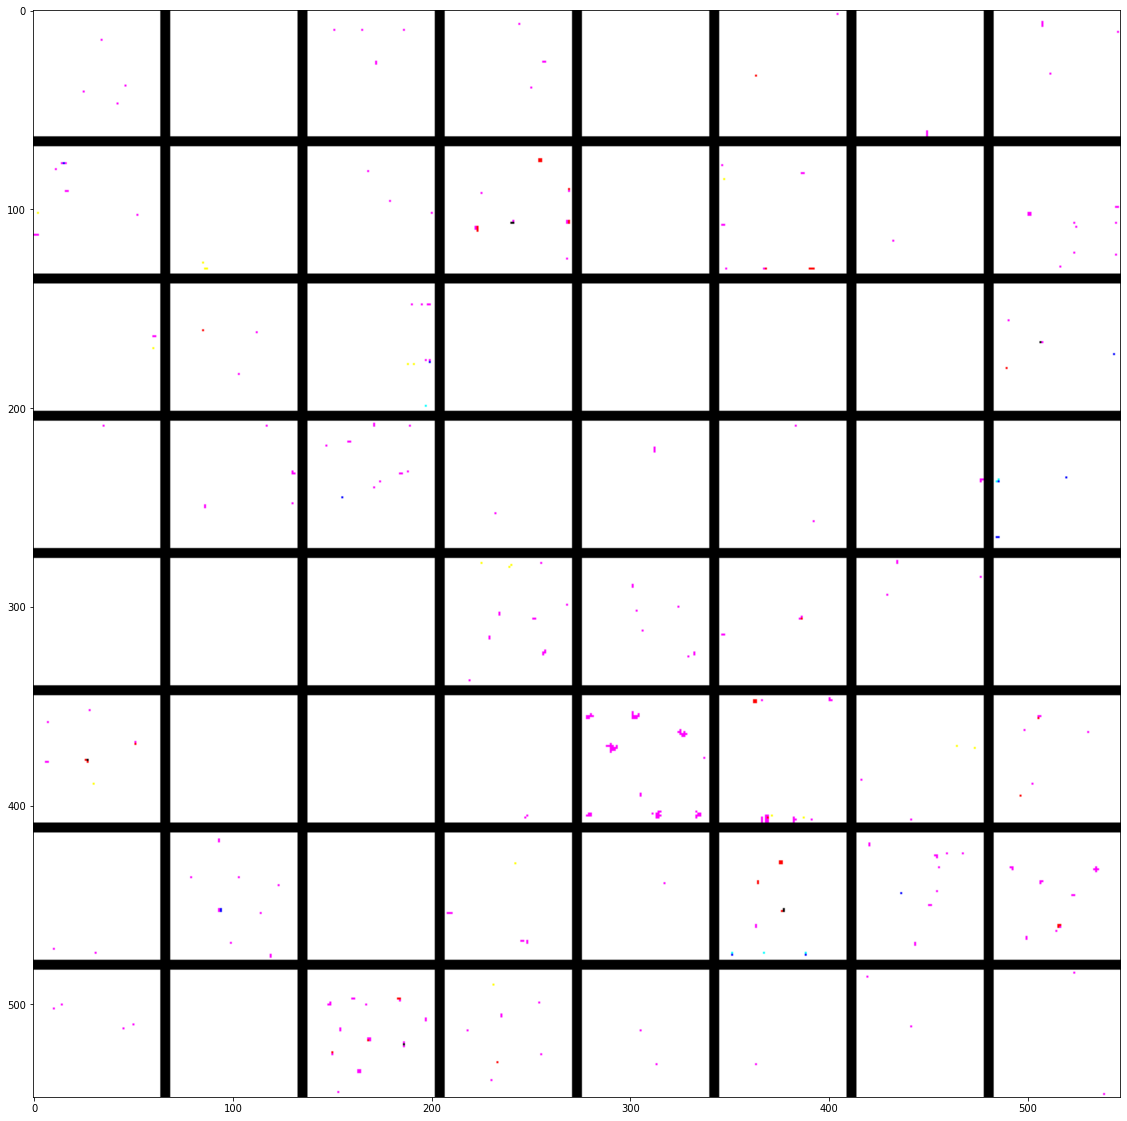

In [56]:
for layer_name in ['block1_conv1','block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5
    
    results = np.zeros((8*size + 7 * margin, 8 * size + 7 * margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i+(j*8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, 
                vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20,20))
plt.imshow(results)
plt.show()